In [1]:
# Script EAPV completo - cálculos de incidências

import pandas as pd
import datetime
import numpy as np
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

df_eventos = pd.read_excel('Relatorios/evento_adverso.xlsx')

data_eapv = df_eventos
data_eapv.shape

(30258, 106)

In [2]:
#### BANCO VACINADOS #### 
#(extrair do painel https://vacina.saude.rs.gov.br - sobre - base de dados - aplicadas)
df_vacinados = pd.read_csv('SESRS_VAC_APLICACAO_09_12_2021-10_33.csv', sep=';', encoding='cp1252')
df_vacinados

# filtrar data até 04-12-2021 (SE 48/2021) - CONFORME BOLETIM
df_vacinados = df_vacinados[df_vacinados['DATA']<= '2021-12-04']
total_aplicadas = df_vacinados['COUNT'].sum()
print(f'Total vacinados: {total_aplicadas}')

# tratar nomes de vacina
df_vacinados.loc[df_vacinados['TP_VACINA'].str.contains('AstraZeneca'), 'TP_VACINA'] = 'Astrazeneca'
df_vacinados['TP_VACINA'].replace('CoronaVac', 'Coronavac', inplace=True)

#### CALCULOS DE INCIDENCIA ####

# total de vacinas aplicadas até 04-12-2021 (SE 48/2021)
total_aplicadas = df_vacinados['COUNT'].sum()

# total de EAPV - sem os erros de imunização e os covid
total_eapv = len(data_eapv)

# Incidência de EVENTOS ADVERSOS por 1000 doses aplicadas
tx_eapvpor1000ds = round((total_eapv/total_aplicadas*1000),2)
print(f'Taxa de incidência de eventos adversos por 1000 doses no RS: {tx_eapvpor1000ds}') #n eventos

Total vacinados: 18157229
Taxa de incidência de eventos adversos por 1000 doses no RS: 1.67


In [3]:
# Agora não temos mais o dataset por pessoa como era antes, e sim por evento/vacina, o que dá um n bem maior
# Verificar incidência de EAPV pelo número da notificação único
notificacoes_eapv = data_eapv['NUMERO DA NOTIFICACAO'].nunique()
print(f'Temos {notificacoes_eapv} notificações de EAPV no período analisado')

# Incidência de Notificações por 1000ds
tx_notif_por1000ds = round((notificacoes_eapv/total_aplicadas*1000),2)
print(f'Taxa geral de incidência de Notificações de EAPV por 1000 doses no RS: {tx_notif_por1000ds}') 
print('O número de notificações não corresponde ao número de indivíduos, pois um indivíduo pode ter tido mais de uma notificação de EAPV (para doses ou vacinas diferentes)')

Temos 10751 notificações de EAPV no período analisado
Taxa geral de incidência de Notificações de EAPV por 1000 doses no RS: 0.59
O número de notificações não corresponde ao número de indivíduos, pois um indivíduo pode ter tido mais de uma notificação de EAPV (para doses ou vacinas diferentes)


In [4]:
total_aplicadas
total_eapv

30258

In [5]:
## REFAZER ESTES CÁLCULOS POR NOTIFICAÇÃO ÚNICA
data_eapv = data_eapv.drop_duplicates(subset=['NUMERO DA NOTIFICACAO'])
data_eapv['VACINA'] = data_eapv['VACINA'].str.replace('Butantan', 'Coronavac')

In [6]:
# TOTAL APLICADAS POR VACINA POR SEXO
df_apl_por_sexo = df_vacinados[['SEXO','TP_VACINA', 'COUNT']]
df_apl_por_sexo.rename(columns={'TP_VACINA' : 'VACINA'}, inplace=True)
df_apl_por_sexo = df_apl_por_sexo.groupby(by=['SEXO', 'VACINA']).sum()
df_apl_por_sexo.reset_index(inplace=True)
#print(df_apl_por_sexo.groupby(by=['SEXO', 'VACINA']).sum().sum())

# TOTAL EAPV POR VACINA POR SEXO
df_eapv_por_sexo = data_eapv[['SEXO', 'VACINA']]
df_eapv_por_sexo['eapv'] = 1
df_eapv_por_sexo = df_eapv_por_sexo.groupby(by=['SEXO', 'VACINA']).sum()
df_eapv_por_sexo.reset_index(inplace=True)

# Merge EAPV e aplicadas por sexo, vacina
df_eapv_apl_sexo_vac = pd.merge(df_apl_por_sexo, df_eapv_por_sexo, left_on=['SEXO', 'VACINA'], right_on=['SEXO', 'VACINA'],
                                how='left')

# Incidência de EAPV por sexo e por vacina (por mil doses aplicadas):
df_eapv_apl_sexo_vac['incidencia_1000ds'] = round((df_eapv_apl_sexo_vac['eapv']/df_eapv_apl_sexo_vac['COUNT']*1000),2)
df_eapv_apl_sexo_vac

,SEXO,VACINA,COUNT,eapv,incidencia_1000ds
0,Feminino,Astrazeneca,3763505,5333,1.42
1,Feminino,Coronavac,2531456,1694,0.67
2,Feminino,Janssen,136420,82,0.60
3,Feminino,Pfizer,3293109,883,0.27
4,Masculino,Astrazeneca,3449109,1793,0.52
5,Masculino,Coronavac,1933452,530,0.27
6,Masculino,Janssen,168024,82,0.49
7,Masculino,Pfizer,2882154,354,0.12


In [7]:
feminino = df_eapv_apl_sexo_vac.loc[df_eapv_apl_sexo_vac['SEXO']=='Feminino']
masculino = df_eapv_apl_sexo_vac.loc[df_eapv_apl_sexo_vac['SEXO']=='Masculino']

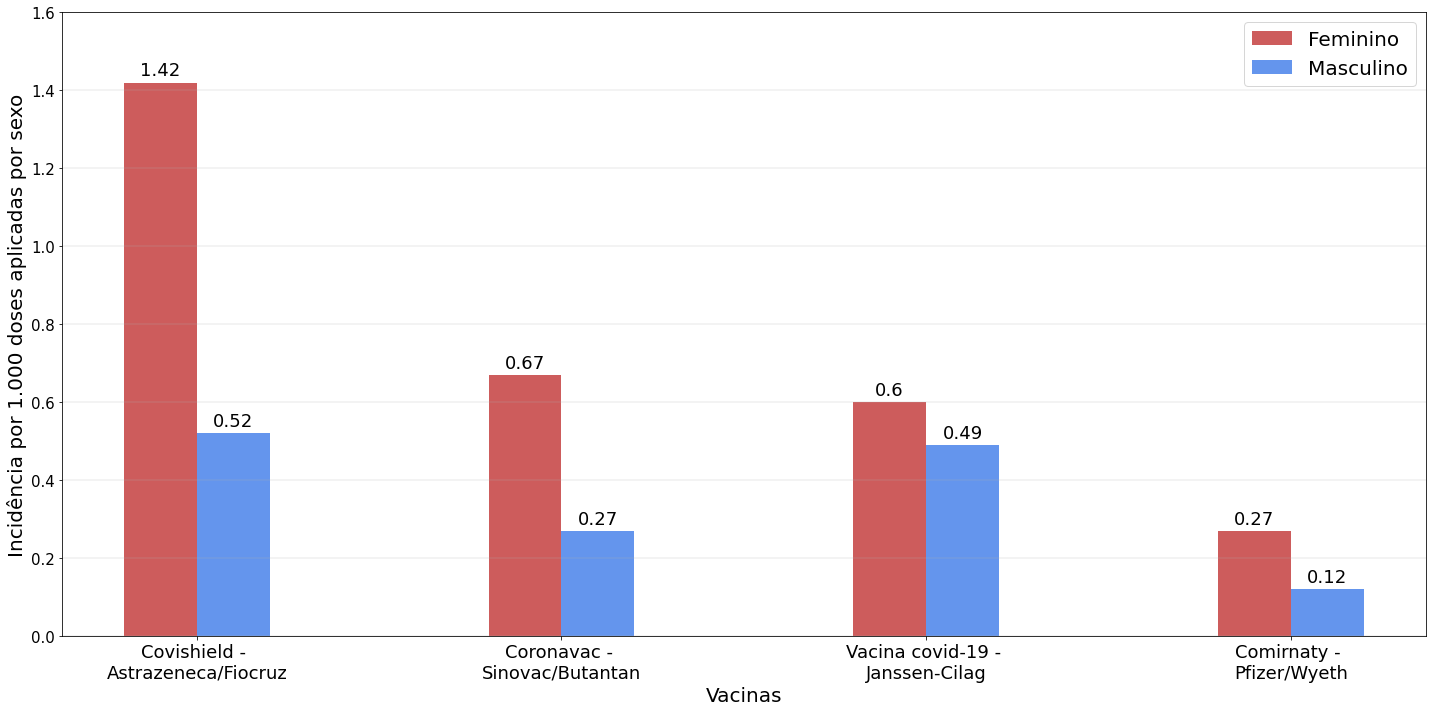

In [8]:
## GRAFICO ##
diameters = feminino['VACINA'].unique()

width = 0.2
x = np.arange(len(diameters))

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width, feminino['incidencia_1000ds'], width=width, label='Feminino', align='center', color='indianred')
rects2 = ax.bar(x, masculino['incidencia_1000ds'], width=width, label='Masculino', align='center', color='cornflowerblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Incidência por 1.000 doses aplicadas por sexo', fontsize=20)
ax.set_xlabel('Vacinas', fontsize=20) # negrito -> weight='bold'
plt.xticks(x-width/2,('Covishield - \nAstrazeneca/Fiocruz','Coronavac - \nSinovac/Butantan','Vacina covid-19 - \nJanssen-Cilag','Comirnaty - \nPfizer/Wyeth'),fontsize=18)
plt.yticks(fontsize=15)
ax.legend(fontsize=20)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=18)


autolabel(rects1)
autolabel(rects2)

plt.ylim(0,1.60)
plt.grid(axis='y', linewidth=0.3)
fig.tight_layout()
plt.savefig('Graficos/Figura 2.png', dpi=(600), bbox_inches='tight', transparent=True)
plt.show()

In [9]:
## DATASETS
# O data_eapv está com as notificações unicas
# o df_eventos está com todos os eventos separados por vacina

In [10]:
# Incidencia de EAPV geral por vacina (por mil doses):
df_eapv_apl_vac = df_eapv_apl_sexo_vac[['VACINA', 'COUNT', 'eapv']]
df_eapv_apl_vac = df_eapv_apl_vac.groupby(by=['VACINA']).sum()
df_eapv_apl_vac.reset_index(inplace=True)
df_eapv_apl_vac['incidencia_1000ds'] = round((df_eapv_apl_vac['eapv']/df_eapv_apl_vac['COUNT']*1000),2)
df_eapv_apl_vac

,VACINA,COUNT,eapv,incidencia_1000ds
0,Astrazeneca,7212614,7126,0.99
1,Coronavac,4464908,2224,0.50
2,Janssen,304444,164,0.54
3,Pfizer,6175263,1237,0.20


In [11]:
# Incidencia de EAPV geral por sexo (por mil doses):
df_eapv_apl_sexo = df_eapv_apl_sexo_vac[['SEXO', 'COUNT', 'eapv']]
df_eapv_apl_sexo = df_eapv_apl_sexo.groupby(by=['SEXO']).sum()
df_eapv_apl_sexo.reset_index(inplace=True)
df_eapv_apl_sexo['incidencia_1000ds'] = round((df_eapv_apl_sexo['eapv']/df_eapv_apl_sexo['COUNT']*1000),2)
df_eapv_apl_sexo

,SEXO,COUNT,eapv,incidencia_1000ds
0,Feminino,9724490,7992,0.82
1,Masculino,8432739,2759,0.33


In [12]:
# TOTAL APLICADAS POR FAIXA ETÁRIA
df_faixas_apl = df_vacinados[['FAIXAETARIA','TP_VACINA', 'COUNT']]
df_faixas_apl.rename(columns={'TP_VACINA' : 'VACINA'}, inplace=True)
df_faixas_apl['FAIXAETARIA'] = df_faixas_apl['FAIXAETARIA'].map(lambda x: re.sub(r' a ', '-', x))
df_faixas_apl['FAIXAETARIA'] = df_faixas_apl['FAIXAETARIA'].map(lambda x: re.sub(r' e mais', '+', x))
df_faixas_apl['FAIXAETARIA'].replace(['12-14', '15-17'], '12-17', inplace=True)
df_faixas_apl = df_faixas_apl.groupby(by=['FAIXAETARIA', 'VACINA']).sum()
df_faixas_apl.reset_index(inplace=True)

# TOTAL EAPV POR VACINA POR FAIXA ETARIA
df_faixas_eapv = data_eapv[['FAIXA ETARIA', 'VACINA']]
df_faixas_eapv['eapv'] = 1
df_faixas_eapv = df_faixas_eapv.groupby(by=['VACINA', 'FAIXA ETARIA']).sum()
df_faixas_eapv.reset_index(inplace=True)

# Merge EAPV e APLICADAS por faixa etária e por vacina
df_faixas_apl_eapv = pd.merge(df_faixas_apl, df_faixas_eapv, left_on=['FAIXAETARIA', 'VACINA'], right_on=['FAIXA ETARIA', 'VACINA'], how='outer')
df_faixas_apl_eapv = df_faixas_apl_eapv[['FAIXAETARIA', 'VACINA', 'COUNT', 'eapv']]
df_faixas_apl_eapv['eapv'].fillna(0, inplace=True)

# Incidência de EAPV por faixa etária e por vacina por 1000 doses
df_faixas_apl_eapv['incidencia_1000ds'] = round((df_faixas_apl_eapv['eapv']/df_faixas_apl_eapv['COUNT']*1000),2)
df_faixas_apl_eapv

,FAIXAETARIA,VACINA,COUNT,eapv,incidencia_1000ds
0,12-17,Pfizer,945803,78.0,0.08
1,18-19,Astrazeneca,96494,134.0,1.39
2,18-19,Coronavac,138662,32.0,0.23
3,18-19,Janssen,3321,6.0,1.81
4,18-19,Pfizer,249826,38.0,0.15
5,20-24,Astrazeneca,328426,601.0,1.83
6,20-24,Coronavac,326685,141.0,0.43
7,20-24,Janssen,11837,9.0,0.76
8,20-24,Pfizer,722221,168.0,0.23
9,25-29,Astrazeneca,440451,768.0,1.74


In [13]:
df_faixas_apl_eapv.loc[df_faixas_apl_eapv['FAIXAETARIA'].str.contains('', na=False), 'Nome Padrão'] = 'Erro de administração da vacina'

In [14]:
# Merge para pegar o total aplicadas por vacina
df_faixas_grafico = df_faixas_apl_eapv[['FAIXAETARIA', 'VACINA', 'COUNT']]
df_faixas_grafico = pd.merge(df_faixas_grafico, df_eapv_apl_vac[['VACINA', 'COUNT']], on='VACINA', how='outer')
df_faixas_grafico.rename(columns={'COUNT_x':'APL POR FAIXA', 'COUNT_y':'APL POR VACINA'}, inplace=True)
df_faixas_grafico

,FAIXAETARIA,VACINA,APL POR FAIXA,APL POR VACINA
0,12-17,Pfizer,945803,6175263
1,18-19,Pfizer,249826,6175263
2,20-24,Pfizer,722221,6175263
3,25-29,Pfizer,700610,6175263
4,30-34,Pfizer,521448,6175263
5,35-39,Pfizer,527224,6175263
6,40-44,Pfizer,461653,6175263
7,45-49,Pfizer,436726,6175263
8,50-54,Pfizer,346009,6175263
9,55-59,Pfizer,202936,6175263


In [1]:
# Porcentagem de vacinados por faixa etaria
df_faixas_grafico['% APLICADAS'] = ((df_faixas_grafico['APL POR FAIXA']/df_faixas_grafico['APL POR VACINA'])*100).round(2)

NameError: name 'df_faixas_grafico' is not defined

In [16]:
pfizer = df_faixas_grafico.loc[df_faixas_grafico['VACINA']=='Pfizer'].reset_index(drop=True)

astrazeneca = df_faixas_grafico.loc[df_faixas_grafico['VACINA']=='Astrazeneca'].reset_index(drop=True)
astrazeneca.at[14]=['12-17', 'Astrazeneca', 0, astrazeneca['APL POR VACINA'][0], 0]
astrazeneca = astrazeneca.sort_values('FAIXAETARIA').reset_index(drop=True)

coronavac = df_faixas_grafico.loc[df_faixas_grafico['VACINA']=='Coronavac'].reset_index(drop=True)
coronavac.at[14]=['12-17', 'Coronavac', 0, coronavac['APL POR VACINA'][0], 0]
coronavac = coronavac.sort_values('FAIXAETARIA').reset_index(drop=True)

janssen = df_faixas_grafico.loc[df_faixas_grafico['VACINA']=='Janssen'].reset_index(drop=True)
janssen.at[14]=['12-17', 'Janssen', 0, janssen['APL POR VACINA'][0], 0]
janssen = janssen.sort_values('FAIXAETARIA').reset_index(drop=True)

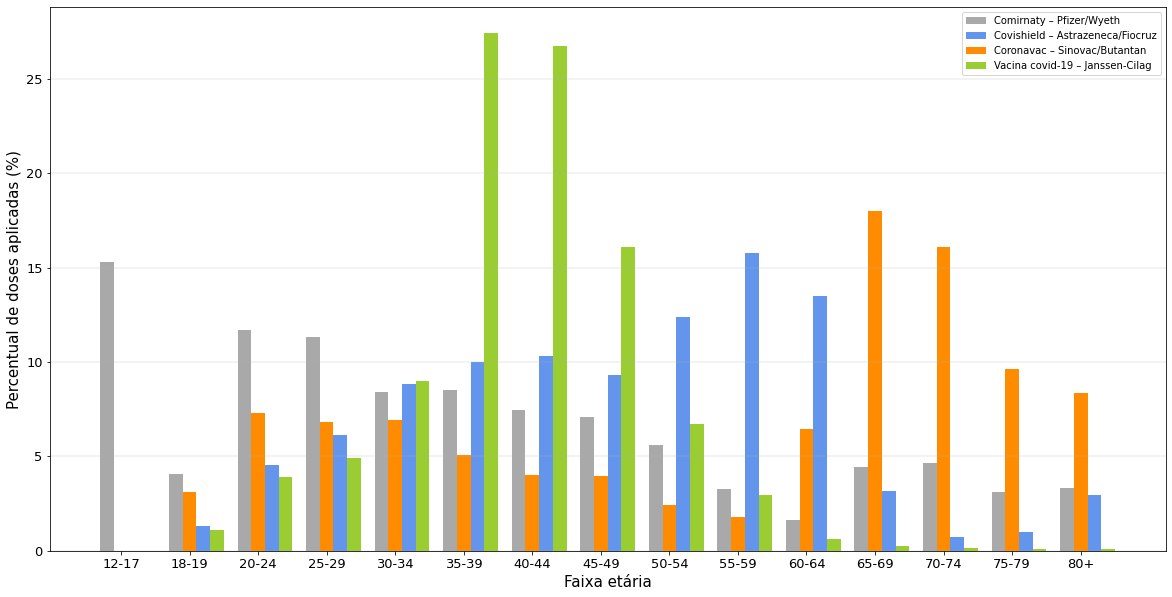

In [17]:
## GRÁFICO ##
fig, ax = plt.subplots(figsize=(20,10))
width = 0.2

x1 = np.arange(len(pfizer['FAIXAETARIA']))
x2 = np.arange(len(astrazeneca['FAIXAETARIA']))
x3 = np.arange(len(coronavac['FAIXAETARIA']))
x4 = np.arange(len(janssen['FAIXAETARIA']))

plt.bar(x1-0.2, pfizer['% APLICADAS'], width, label = 'Comirnaty – Pfizer/Wyeth', color='darkgray')
plt.bar(x2+0.2, astrazeneca['% APLICADAS'], width, label = 'Covishield – Astrazeneca/Fiocruz', color='cornflowerblue')
plt.bar(x3, coronavac['% APLICADAS'], width, label = 'Coronavac – Sinovac/Butantan', color='darkorange')
plt.bar(x4+0.4, janssen['% APLICADAS'], width, label = 'Vacina covid-19 – Janssen-Cilag', color='yellowgreen')

plt.xticks(np.arange(0,15,1), (df_faixas_grafico['FAIXAETARIA'].unique()), fontsize=13)
plt.yticks(fontsize=13)

plt.ylabel('Percentual de doses aplicadas (%)', fontsize=15)
plt.xlabel('Faixa etária', fontsize=15)

plt.grid(axis='y', linewidth=0.3)
plt.legend()
plt.savefig('Graficos/Figura 7.png', dpi=(600), bbox_inches='tight', transparent=True)
plt.show()

In [18]:
# FAIXA ETÁRIA, VACINAS E GRAVIDADE
# TOTAL APLICADAS POR FAIXA ETÁRIA
df_faixas_apl = df_vacinados[['FAIXAETARIA','TP_VACINA', 'COUNT']]
df_faixas_apl.rename(columns={'TP_VACINA' : 'VACINA'}, inplace=True)
df_faixas_apl['FAIXAETARIA'] = df_faixas_apl['FAIXAETARIA'].map(lambda x: re.sub(r' a ', '-', x))
df_faixas_apl['FAIXAETARIA'] = df_faixas_apl['FAIXAETARIA'].map(lambda x: re.sub(r' e mais', '+', x))
df_faixas_apl['FAIXAETARIA'].replace(['12-14', '15-17'], '12-17', inplace=True)
df_faixas_apl = df_faixas_apl.groupby(by=['FAIXAETARIA', 'VACINA']).sum()
df_faixas_apl.reset_index(inplace=True)

# TOTAL EAPV POR VACINA POR FAIXA ETARIA, CLASSIFICAÇÃO DE GRAVIDADE
df_faixas_eapv = df_eventos[['FAIXA ETARIA', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE']]
df_faixas_eapv['eapv'] = 1
df_faixas_eapv = df_faixas_eapv.groupby(by=['VACINA', 'CLASSIFICACAO DE GRAVIDADE', 'FAIXA ETARIA']).sum()
df_faixas_eapv.reset_index(inplace=True)
df_faixas_eapv.loc[df_faixas_eapv['VACINA']=='Butantan', 'VACINA']= 'Coronavac'

In [19]:
# EAPV não graves
df_faixas_eapv_ng = df_faixas_eapv[df_faixas_eapv['CLASSIFICACAO DE GRAVIDADE']=='Não grave']

# Merge EAPV e APLICADAS por faixa etária e por vacina
df_faixas_apl_eapv_ng = pd.merge(df_faixas_apl, df_faixas_eapv_ng, left_on=['FAIXAETARIA', 'VACINA'], right_on=['FAIXA ETARIA', 'VACINA'], how='outer')
df_faixas_apl_eapv_ng = df_faixas_apl_eapv_ng[['FAIXAETARIA', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE', 'COUNT', 'eapv']]
df_faixas_apl_eapv_ng['eapv'].fillna(0, inplace=True)

# Incidência de EAPV por faixa etária e por vacina por 1000 doses
df_faixas_apl_eapv_ng['incidencia_1000ds'] = round((df_faixas_apl_eapv_ng['eapv']/df_faixas_apl_eapv_ng['COUNT']*1000),2)
df_faixas_apl_eapv_ng

,FAIXAETARIA,VACINA,CLASSIFICACAO DE GRAVIDADE,COUNT,eapv,incidencia_1000ds
0,12-17,Pfizer,Não grave,945803,166.0,0.18
1,18-19,Astrazeneca,Não grave,96494,388.0,4.02
2,18-19,Coronavac,Não grave,138662,103.0,0.74
3,18-19,Janssen,Não grave,3321,23.0,6.93
4,18-19,Pfizer,Não grave,249826,102.0,0.41
5,20-24,Astrazeneca,Não grave,328426,1792.0,5.46
6,20-24,Coronavac,Não grave,326685,355.0,1.09
7,20-24,Janssen,Não grave,11837,23.0,1.94
8,20-24,Pfizer,Não grave,722221,417.0,0.58
9,25-29,Astrazeneca,Não grave,440451,2189.0,4.97


In [20]:
df_faixas_apl_eapv_ng['CLASSIFICACAO DE GRAVIDADE'].fillna('Não grave', inplace=True)

In [21]:
pfizer_ng = df_faixas_apl_eapv_ng.loc[df_faixas_apl_eapv_ng['VACINA']=='Pfizer'].reset_index(drop=True)

astrazeneca_ng = df_faixas_apl_eapv_ng.loc[df_faixas_apl_eapv_ng['VACINA']=='Astrazeneca'].reset_index(drop=True)
astrazeneca_ng.at[14]=['12-17', 'Astrazeneca', astrazeneca_ng['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
astrazeneca_ng = astrazeneca_ng.sort_values('FAIXAETARIA').reset_index(drop=True)

coronavac_ng = df_faixas_apl_eapv_ng.loc[df_faixas_apl_eapv_ng['VACINA']=='Coronavac'].reset_index(drop=True)
coronavac_ng.at[14]=['12-17', 'Coronavac', coronavac_ng['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
coronavac_ng = coronavac_ng.sort_values('FAIXAETARIA').reset_index(drop=True)

janssen_ng = df_faixas_apl_eapv_ng.loc[df_faixas_apl_eapv_ng['VACINA']=='Janssen'].reset_index(drop=True)
janssen_ng.at[14]=['12-17', 'Janssen', janssen_ng['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
janssen_ng = janssen_ng.sort_values('FAIXAETARIA').reset_index(drop=True)

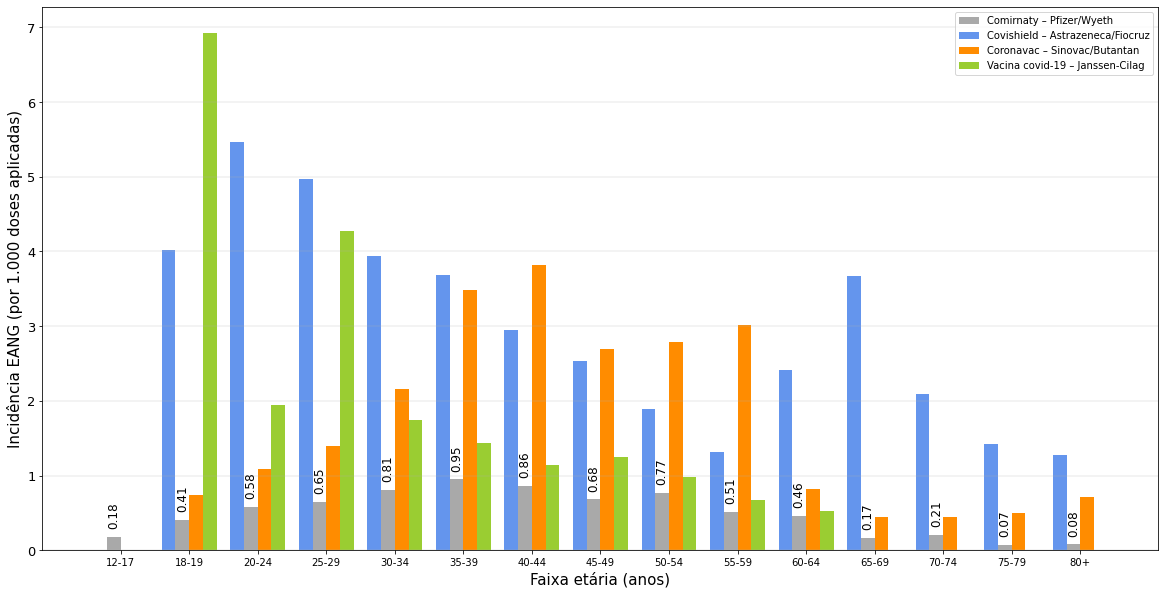

In [22]:
## TENTATIVA FRUSTRADA ## FALTARAM OS VALORES NA BARRA 
fig, ax = plt.subplots(figsize=(20,10))
width = 0.2
width1 = 1

x1 = np.arange(len(pfizer_ng['FAIXAETARIA']))
x2 = np.arange(len(astrazeneca_ng['FAIXAETARIA']))
x3 = np.arange(len(coronavac_ng['FAIXAETARIA']))
x4 = np.arange(len(janssen_ng['FAIXAETARIA']))

plt.bar(x1, pfizer_ng['incidencia_1000ds'], width, label = 'Comirnaty – Pfizer/Wyeth', color='darkgray')
plt.bar(x2-width, astrazeneca_ng['incidencia_1000ds'], width, label = 'Covishield – Astrazeneca/Fiocruz', color='cornflowerblue')
plt.bar(x3+width, coronavac_ng['incidencia_1000ds'], width, label = 'Coronavac – Sinovac/Butantan', color='darkorange')
plt.bar(x4+width*2, janssen_ng['incidencia_1000ds'], width, label = 'Vacina covid-19 – Janssen-Cilag', color='yellowgreen')

#plt.xticks(np.arange(0,15,1), (df_faixas_grafico['FAIXAETARIA'].unique()), fontsize=13)
plt.xticks(x1+width/2, df_faixas_grafico['FAIXAETARIA'].unique())
plt.yticks(fontsize=13)

plt.ylabel('Incidência EANG (por 1.000 doses aplicadas)', fontsize=15)
plt.xlabel('Faixa etária (anos)', fontsize=15)

#colocar valores na barra
for i in range(len(x1)):
        plt.text(i, pfizer_ng['incidencia_1000ds'][i] + 0.15, pfizer_ng['incidencia_1000ds'][i], ha = 'center', fontsize=12, rotation=90)

#for i in range(len(x2)):
#        plt.text(i, astrazeneca_ng['incidencia_1000ds'][i] + 0.25, astrazeneca_ng['incidencia_1000ds'][i], ha = 'center', fontsize=12, rotation=90)

plt.grid(axis='y', linewidth=0.3)
plt.legend()
plt.show()

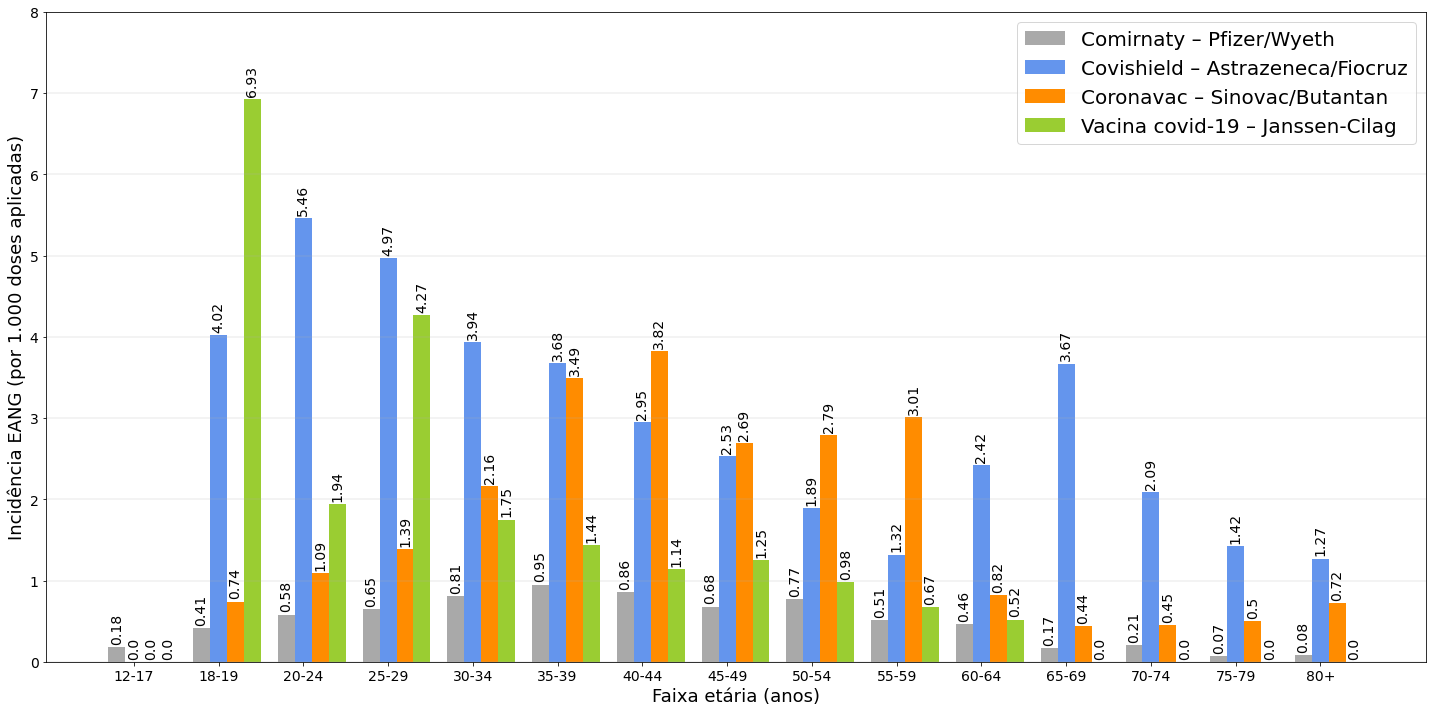

In [23]:
## GRÁFICO ##
diameters = df_faixas_grafico['FAIXAETARIA'].unique()

width = 0.2
x = np.arange(len(diameters))

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width, pfizer_ng['incidencia_1000ds'], width=width, label='Comirnaty – Pfizer/Wyeth', align='center', color='darkgray')
rects2 = ax.bar(x, astrazeneca_ng['incidencia_1000ds'], width=width, label='Covishield – Astrazeneca/Fiocruz', align='center', color='cornflowerblue')
rects3 = ax.bar(x + width, coronavac_ng['incidencia_1000ds'], width=width, label='Coronavac – Sinovac/Butantan', align='center', color='darkorange')
rects4 = ax.bar(x + width*2, janssen_ng['incidencia_1000ds'], width=width, label='Vacina covid-19 – Janssen-Cilag', align='center', color='yellowgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Incidência EANG (por 1.000 doses aplicadas)', fontsize=18)
ax.set_xlabel('Faixa etária (anos)', fontsize=18)
ax.set_xticks(x)
plt.xticks(fontsize=14)
ax.set_xticklabels(diameters)
plt.yticks(fontsize=14)
ax.legend(fontsize=20)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom', rotation=90, fontsize=14)


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.ylim(0,8)
plt.grid(axis='y', linewidth=0.3)
fig.tight_layout()
plt.savefig('Graficos/Figura 8.png', dpi=(600), bbox_inches='tight', transparent=True)
plt.show()

In [24]:
# EAPV Graves
df_faixas_eapv_g = df_faixas_eapv[df_faixas_eapv['CLASSIFICACAO DE GRAVIDADE']=='Grave']

# Merge EAPV e APLICADAS por faixa etária e por vacina
df_faixas_apl_eapv_g = pd.merge(df_faixas_apl, df_faixas_eapv_g, left_on=['FAIXAETARIA', 'VACINA'], right_on=['FAIXA ETARIA', 'VACINA'], how='outer')
df_faixas_apl_eapv_g = df_faixas_apl_eapv_g[['FAIXAETARIA', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE', 'COUNT', 'eapv']]
df_faixas_apl_eapv_g['eapv'].fillna(0, inplace=True)

# Incidência de EAPV por faixa etária e por vacina por 100 mil doses
df_faixas_apl_eapv_g['incidencia_1000ds'] = round((df_faixas_apl_eapv_g['eapv']/df_faixas_apl_eapv_g['COUNT']*100000),2)
df_faixas_apl_eapv_g

,FAIXAETARIA,VACINA,CLASSIFICACAO DE GRAVIDADE,COUNT,eapv,incidencia_1000ds
0,12-17,Pfizer,Grave,945803,16.0,1.69
1,18-19,Astrazeneca,Grave,96494,4.0,4.15
2,18-19,Coronavac,NaN,138662,0.0,0.00
3,18-19,Janssen,NaN,3321,0.0,0.00
4,18-19,Pfizer,Grave,249826,5.0,2.00
5,20-24,Astrazeneca,Grave,328426,21.0,6.39
6,20-24,Coronavac,Grave,326685,2.0,0.61
7,20-24,Janssen,NaN,11837,0.0,0.00
8,20-24,Pfizer,Grave,722221,7.0,0.97
9,25-29,Astrazeneca,Grave,440451,29.0,6.58


In [25]:
#colocar 'Grave' nos NaN
df_faixas_apl_eapv_g['CLASSIFICACAO DE GRAVIDADE'].fillna('Grave', inplace=True)

In [26]:
# separando vacinas e colocando 0 nas vacinas que não foram aplicadas em 12-17 para não dar erro no gráfico
pfizer_g = df_faixas_apl_eapv_g.loc[df_faixas_apl_eapv_g['VACINA']=='Pfizer'].reset_index(drop=True)

astrazeneca_g = df_faixas_apl_eapv_g.loc[df_faixas_apl_eapv_g['VACINA']=='Astrazeneca'].reset_index(drop=True)
astrazeneca_g.at[14]=['12-17', 'Astrazeneca', astrazeneca_g['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
astrazeneca_g = astrazeneca_g.sort_values('FAIXAETARIA').reset_index(drop=True)

coronavac_g = df_faixas_apl_eapv_g.loc[df_faixas_apl_eapv_g['VACINA']=='Coronavac'].reset_index(drop=True)
coronavac_g.at[14]=['12-17', 'Coronavac', coronavac_g['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
coronavac_g = coronavac_g.sort_values('FAIXAETARIA').reset_index(drop=True)

janssen_g = df_faixas_apl_eapv_g.loc[df_faixas_apl_eapv_g['VACINA']=='Janssen'].reset_index(drop=True)
janssen_g.at[14]=['12-17', 'Janssen', janssen_g['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
janssen_g = janssen_g.sort_values('FAIXAETARIA').reset_index(drop=True)

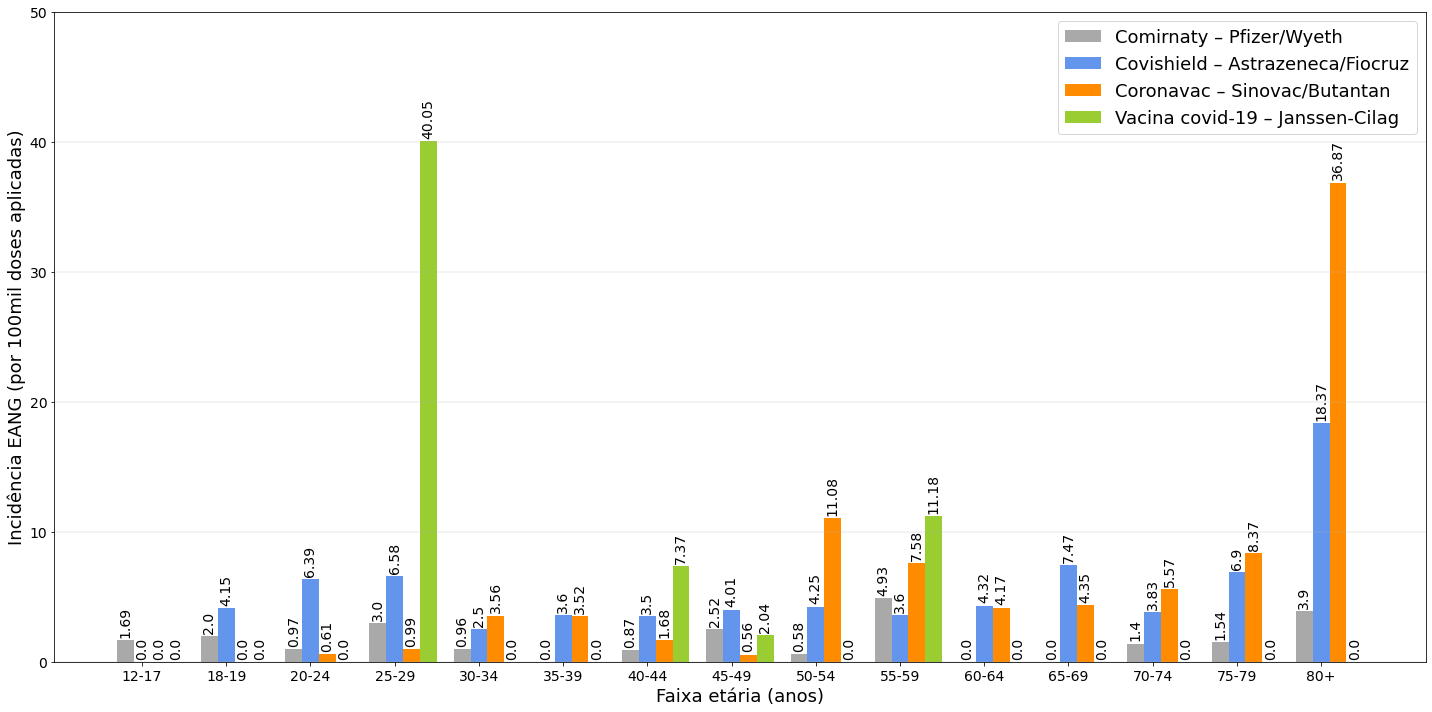

In [27]:
## GRÁFICO ##
diameters = df_faixas_grafico['FAIXAETARIA'].unique()

width = 0.2
x = np.arange(len(diameters))

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width, pfizer_g['incidencia_1000ds'], width=width, label='Comirnaty – Pfizer/Wyeth', align='center', color='darkgray')
rects2 = ax.bar(x, astrazeneca_g['incidencia_1000ds'], width=width, label='Covishield – Astrazeneca/Fiocruz', align='center', color='cornflowerblue')
rects3 = ax.bar(x + width, coronavac_g['incidencia_1000ds'], width=width, label='Coronavac – Sinovac/Butantan', align='center', color='darkorange')
rects4 = ax.bar(x + width*2, janssen_g['incidencia_1000ds'], width=width, label='Vacina covid-19 – Janssen-Cilag', align='center', color='yellowgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Incidência EANG (por 100mil doses aplicadas)', fontsize=18)
ax.set_xlabel('Faixa etária (anos)', fontsize=18)
ax.set_xticks(x)
plt.xticks(fontsize=14)
ax.set_xticklabels(diameters)
plt.yticks(fontsize=14)
ax.legend(fontsize=18)

# adicionar valores na barra
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom', rotation=90, fontsize=14)


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.ylim(0,50)
plt.grid(axis='y', linewidth=0.3)
fig.tight_layout()
plt.savefig('Graficos/Figura 9.png', dpi=(600), bbox_inches='tight', transparent=True)
plt.show()

# Mapa interativo

In [28]:
# Vacinados por município de residência
df_vac_mun = df_vacinados[['TP_VACINA', 'CD_MUNICIPIO', 'COUNT']]
df_vac_mun = df_vac_mun.groupby(by=['CD_MUNICIPIO']).sum().reset_index()
df_vac_mun['CD_MUNICIPIO'] = df_vac_mun['CD_MUNICIPIO'].astype('str')

# Arquivo com o nome dos municípios
df_nome_mun = pd.read_csv('SESRS - Imunização Covid-19RS (1).csv', sep=',', encoding='utf8', dtype='str')
df_nome_mun = df_nome_mun[['CRS', 'Município']]
df_nome_mun[['codigo', 'municipio']] = df_nome_mun['Município'].str.split(' - ', expand=True)
df_nome_mun = df_nome_mun[['CRS', 'codigo', 'municipio']]
df_nome_mun['codigo'] = df_nome_mun['codigo'].astype('str')

# Merge para pegar o nome pelo código IBGE
df_vac_mun = pd.merge(df_vac_mun, df_nome_mun, left_on='CD_MUNICIPIO', right_on='codigo', how='outer')
df_vac_mun = df_vac_mun[['municipio', 'COUNT']]

# TOTAL EAPV POR MUNICIPIO
df_eapv_mun = data_eapv[['MUNICIPIO DE RESIDENCIA']]
df_eapv_mun['eapv'] = 1
df_eapv_mun = df_eapv_mun.groupby(by=['MUNICIPIO DE RESIDENCIA']).sum()
df_eapv_mun.reset_index(inplace=True)
#df_eapv_mun.to_excel('df_eapv_mun.xlsx')

# Acentuar os municípios para plotar no gráfico
# Ler o arquivo acentuado
df_eapv_mun_com_acentos = pd.read_excel('df_eapv_mun_com_acentos.xlsx') #'df_eapv_mun_com_acentos.xlsx'
df_eapv_mun_com_acentos.drop(columns=['Unnamed: 0'], inplace=True)
df_eapv_mun_com_acentos.rename(columns={'MUNICIPIO DE RESIDENCIA' : 'municipio'}, inplace=True)

# Merge EAPV com aplicadas por município
df_eapv_apl_mun = pd.merge(df_vac_mun, df_eapv_mun_com_acentos, on='municipio', how='outer')
df_eapv_apl_mun = df_eapv_apl_mun.fillna(0)

# Calculo da incidência por município
df_eapv_apl_mun['incidencia_1000ds'] = round((df_eapv_apl_mun['eapv'] / df_eapv_apl_mun['COUNT'] * 1000),2)
df_eapv_apl_mun

##### Arquivo para MAPA ####
df_eapv_apl_mun_incid = df_eapv_apl_mun[['municipio', 'incidencia_1000ds']]
df_eapv_apl_mun_incid.to_excel('municipios_incidencia_EAPV.xlsx', index=False)


In [29]:
teste = df_eapv_apl_mun_incid.sort_values(by='incidencia_1000ds')
teste.tail(20)

,municipio,incidencia_1000ds
115,Coqueiros do Sul,3.42
438,Tapejara,3.46
282,Nova Ramada,3.59
463,Tucunduva,3.67
274,Nova Bréscia,3.94
119,Cotiporã,4.32
302,Passa Sete,4.58
212,Itapuca,4.84
465,Tupanci do Sul,5.28
249,Mato Castelhano,5.30


A PARTIR DAQUI USAMOS O BANCO COM O NUMERO DE EVENTOS ADVERSOS
| BANCO EVENTO ADVERSO (n=32.922)

In [30]:
## A PARTIR DAQUI USAMOS O BANCO COM O NUMERO DE EVENTOS ADVERSOS
# BANCO EVENTO ADVERSO (n=32.922)

# Fazer incidências por Grave x não Grave e vacina e sexo
df_eventos.shape

(30258, 106)

In [31]:
df_eventos['VACINA'].unique()

array(['Astrazeneca', 'Pfizer', 'Butantan', 'Janssen'], dtype=object)

In [32]:
# Ajusta nome 
df_eventos['VACINA'] = df_eventos['VACINA'].str.replace('Butantan', 'Coronavac')

In [33]:
df_eventos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30258 entries, 0 to 30257
Columns: 106 entries, NUMERO DA NOTIFICACAO to OBITO
dtypes: datetime64[ns](3), float64(23), int64(3), object(77)
memory usage: 24.5+ MB


In [34]:
# Distribuição de eventos adversos por gravidade e vacina por 1000 doses
df_eventos_vac_gng = df_eventos[['CLASSIFICACAO DE GRAVIDADE', 'VACINA']]
df_eventos_vac_gng['eventos'] = 1
df_eventos_vac_gng = df_eventos_vac_gng.groupby(by=['VACINA', 'CLASSIFICACAO DE GRAVIDADE']).sum().reset_index()
df_eventos_vac_gng

,VACINA,CLASSIFICACAO DE GRAVIDADE,eventos
0,Astrazeneca,Grave,333
1,Astrazeneca,Não grave,20298
2,Coronavac,Grave,307
3,Coronavac,Não grave,5442
4,Janssen,Grave,14
5,Janssen,Não grave,459
6,Pfizer,Grave,96
7,Pfizer,Não grave,3309


In [35]:
#Total de grave e não grave
df_eventos_vac_gng_graf = df_eventos_vac_gng.groupby(by=['CLASSIFICACAO DE GRAVIDADE']).sum().reset_index()
df_eventos_vac_gng_graf

,CLASSIFICACAO DE GRAVIDADE,eventos
0,Grave,750
1,Não grave,29508


In [36]:
# MÉDIANA DE IDADE EAG e EANG
df_media_idade = df_eventos[['IDADE EVENTO', 'CLASSIFICACAO DE GRAVIDADE']]
df_media_idade_EAG = df_media_idade[df_media_idade['CLASSIFICACAO DE GRAVIDADE'] == 'Grave']
df_media_idade_EANG = df_media_idade[df_media_idade['CLASSIFICACAO DE GRAVIDADE'] == 'Não grave']

import statistics as sta
mediana = sta.median(df_media_idade_EAG['IDADE EVENTO'])
print('Mediana de idade EAG: ', mediana)

Mediana de idade EAG:  60.0


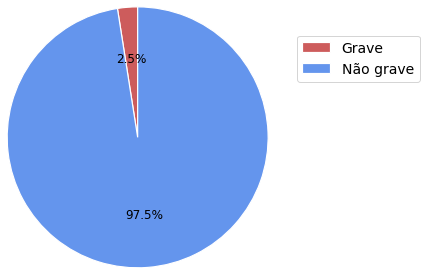

In [37]:
## GRÁFICO ##
colors = ['indianred', 'cornflowerblue']
plt.pie(df_eventos_vac_gng_graf['eventos'], 
        autopct='%1.1f%%',                   #valores em porcentagem
        startangle=90,                       #iniciando no angulo 90
        radius=1.5,                          #tamanho do raio
        textprops={'fontsize': 12},          #tamanho da fonte
        colors=colors,                       #cores
        wedgeprops = {"edgecolor" : "white", #borda
                      'linewidth': 1.2, 
                      'antialiased': True})

plt.legend(df_eventos_vac_gng_graf['CLASSIFICACAO DE GRAVIDADE'], loc=0, bbox_to_anchor=(1.2, 1), fontsize=14)

plt.savefig('Graficos/figura 3.png',dpi=(600), bbox_inches='tight')
plt.show()

In [38]:
# Pegar totais aplicados por vacina do df_vacinados
df_apl_por_vacina = df_vacinados[['TP_VACINA', 'COUNT']]
df_apl_por_vacina = df_apl_por_vacina.groupby(by=['TP_VACINA']).sum()
df_apl_por_vacina.reset_index(inplace=True)
df_apl_por_vacina

,TP_VACINA,COUNT
0,Astrazeneca,7212614
1,Coronavac,4464908
2,Janssen,304444
3,Pfizer,6175263


In [39]:
# Inserir totais de vacina na tabela eventos GRAVE x não grave para calculo da taxa
df_eventos_vac_gng_apl = pd.merge(df_eventos_vac_gng, df_apl_por_vacina, left_on='VACINA', right_on='TP_VACINA', how='left')
df_eventos_vac_gng_apl = df_eventos_vac_gng_apl[['VACINA', 'CLASSIFICACAO DE GRAVIDADE', 'eventos', 'COUNT']]

# Cálculo da Incidência de EAPV GRAVE e NAO GRAVE por vacina por 1000 doses aplicadas
df_eventos_vac_gng_apl['incidencia_1000ds'] = round((df_eventos_vac_gng_apl['eventos'] / df_eventos_vac_gng_apl['COUNT'] * 1000),2)
df_eventos_vac_gng_apl

,VACINA,CLASSIFICACAO DE GRAVIDADE,eventos,COUNT,incidencia_1000ds
0,Astrazeneca,Grave,333,7212614,0.05
1,Astrazeneca,Não grave,20298,7212614,2.81
2,Coronavac,Grave,307,4464908,0.07
3,Coronavac,Não grave,5442,4464908,1.22
4,Janssen,Grave,14,304444,0.05
5,Janssen,Não grave,459,304444,1.51
6,Pfizer,Grave,96,6175263,0.02
7,Pfizer,Não grave,3309,6175263,0.54


In [40]:
# eventos adversos por vacina x gravidade x sexo

# Pegar totais aplicados por vacina do df_vacinados
df_apl_por_sexo

# Distribuição de eventos adversos por gravidade x vacina x sexo por 1000 doses
df_eventos_vac_gng_sex = df_eventos[['SEXO', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE']]
df_eventos_vac_gng_sex['eventos'] = 1
df_eventos_vac_gng_sex = df_eventos_vac_gng_sex.groupby(by=['SEXO', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE']).sum().reset_index()

# merge
df_eventos_vac_gng_sex_apl = pd.merge(df_eventos_vac_gng_sex, df_apl_por_sexo, on=['SEXO', 'VACINA'] , how='outer')

# Cálculo da incidência de EAPV por sxo, vacina, gravidade por 1000ds aplicadas
df_eventos_vac_gng_sex_apl['incidencia_1000ds'] = round((df_eventos_vac_gng_sex_apl['eventos'] / df_eventos_vac_gng_sex_apl['COUNT'] * 1000),2)
df_eventos_vac_gng_sex_apl

,SEXO,VACINA,CLASSIFICACAO DE GRAVIDADE,eventos,COUNT,incidencia_1000ds
0,Feminino,Astrazeneca,Grave,178,3763505,0.05
1,Feminino,Astrazeneca,Não grave,15724,3763505,4.18
2,Feminino,Coronavac,Grave,171,2531456,0.07
3,Feminino,Coronavac,Não grave,4324,2531456,1.71
4,Feminino,Janssen,Grave,14,136420,0.10
5,Feminino,Janssen,Não grave,233,136420,1.71
6,Feminino,Pfizer,Grave,49,3293109,0.01
7,Feminino,Pfizer,Não grave,2407,3293109,0.73
8,Masculino,Astrazeneca,Grave,155,3449109,0.04
9,Masculino,Astrazeneca,Não grave,4574,3449109,1.33


# Gestantes

In [41]:
### VACINAS APLICADAS EM GESTANTES ###
# Ver numero de aplicadas em gestantes no RS
df_gestantes = df_vacinados[df_vacinados['DETALHEGRUPO'] == 'Gestante']
df_gestantes = df_gestantes[['DOSE', 'TP_VACINA']]
print(df_gestantes.shape)

# Gestantes x tipo de vacina aplicada
gestantes_vacina = pd.pivot_table(df_gestantes, values='DOSE', index=['TP_VACINA'], aggfunc='count').reset_index()
gestantes_vacina

(67400, 2)


,TP_VACINA,DOSE
0,Astrazeneca,7540
1,Coronavac,4841
2,Janssen,33
3,Pfizer,54986


In [42]:
### EAPV EM GESTANTES ###
eapv_gestantes = data_eapv[data_eapv['GESTANTE NO MOMENTO DA VACINACAO?'] == 'Sim']
eapv_gestantes = eapv_gestantes[['NUMERO DA NOTIFICACAO', 'IDADE EVENTO', 'MUNICIPIO DE RESIDENCIA', 'NOME COMPLETO', 
                                 'DOSE', 'DATA DA APLICACAO', 'DESCRICAO DO CASO', 'REACAO / EVENTO ADVERSO',
                                 'CODIGO EVENTO ADVERSO', 'DATA DE INICIO', 'TIPO DE EVENTO', 'CLASSIFICACAO DE GRAVIDADE', 'GRAVIDADE',
                                 'DESFECHO (EVOLUCAO DO CASO)', 'DATA DESFECHO', 'DOENCAS (CID10)',
                                 'DESCRICAO DETALHADA DO EVENTO ADVERSO', 'HOUVE ATENDIMENTO MEDICO?', 'TIPO DE ATENDIMENTO', 
                                 'OBSERVACOES COMPLEMENTARES', 'NOME DO EXAME', 'RESULTADO DO EXAME',
                                 'DATA DA REALIZACAO DO EXAME', 'FAIXA ETARIA', 
                                 'NOME_EXAME', 'RESULTADO_EXAME', 'COVID_POSITIVO', 'OBITO', 'VACINA']]
#eapv_gestantes.to_excel('gestantes_BE04.xlsx', index=False)

# Mediana de idade GESTANTES com EAPV
mediana_gestantes = eapv_gestantes['IDADE EVENTO'].median()
mediana_gestantes_graves = eapv_gestantes[eapv_gestantes['CLASSIFICACAO DE GRAVIDADE'].str.contains('Grave')]['IDADE EVENTO'].median()
mediana_gestantes_naograves = eapv_gestantes[eapv_gestantes['CLASSIFICACAO DE GRAVIDADE'].str.contains('Não')]['IDADE EVENTO'].median()
print(f'Mediana de idade das gestantes: {mediana_gestantes}')
print(f'Mediana de idade das gestantes com eventos Graves: {mediana_gestantes_graves}')
print(f'Mediana de idade das gestantes com eventos Não graves: {mediana_gestantes_naograves}')

# Gestantes x EAPV por tipo de vacina aplicada e gravidade
eapv_gestantes_vacina = pd.pivot_table(eapv_gestantes, values='NUMERO DA NOTIFICACAO', index=['VACINA', 'CLASSIFICACAO DE GRAVIDADE'], aggfunc='count').reset_index()
eapv_gestantes_vacina

# Merge com aplicadas:
eapv_gestantes_vacina = pd.merge(eapv_gestantes_vacina, gestantes_vacina, left_on='VACINA', right_on='TP_VACINA', how='outer' )

eapv_gestantes_vacina = eapv_gestantes_vacina[['TP_VACINA', 'CLASSIFICACAO DE GRAVIDADE', 'NUMERO DA NOTIFICACAO', 'DOSE']]
eapv_gestantes_vacina.rename(columns={'TP_VACINA': 'vacina', 'CLASSIFICACAO DE GRAVIDADE': 'gravidade', 'NUMERO DA NOTIFICACAO': 'EAPV', 'DOSE': 'aplicadas'}, inplace=True)

# Incidência de EAPV em gestantes vacinadas por 1000 doses aplicadas
eapv_gestantes_vacina['incidencia'] = (eapv_gestantes_vacina['EAPV'] / eapv_gestantes_vacina['aplicadas'] * 1000).round(2)

eapv_gestantes_vacina.fillna(0, inplace=True)

Mediana de idade das gestantes: 30.0
Mediana de idade das gestantes com eventos Graves: 29.0
Mediana de idade das gestantes com eventos Não graves: 30.0


In [43]:
eapv_gestantes_vacina

,vacina,gravidade,EAPV,aplicadas,incidencia
0,Astrazeneca,Grave,5.0,7540,0.66
1,Astrazeneca,Não grave,138.0,7540,18.30
2,Coronavac,Não grave,21.0,4841,4.34
3,Pfizer,Grave,6.0,54986,0.11
4,Pfizer,Não grave,48.0,54986,0.87
5,Janssen,0,0.0,33,0.00


In [44]:
eapv_gest_vac = eapv_gestantes_vacina.groupby(by=['vacina', 'aplicadas']).sum().reset_index()
eapv_gest_vac['incidencia'] = (eapv_gest_vac['EAPV'] / eapv_gest_vac['aplicadas'] * 1000).round(2)
eapv_gest_vac

,vacina,aplicadas,EAPV,incidencia
0,Astrazeneca,7540,143.0,18.97
1,Coronavac,4841,21.0,4.34
2,Janssen,33,0.0,0.00
3,Pfizer,54986,54.0,0.98


In [45]:
## Total de eventos em gestantes e gravidade x taxa de incidência por 1000 doses
total_eapv_incid = pd.pivot_table(eapv_gestantes_vacina, values='EAPV', index=['gravidade'], aggfunc='sum').reset_index()
total_eapv_incid['incidencia'] = (total_eapv_incid['EAPV'] / 41527 *1000).round(2)
total_eapv_incid = total_eapv_incid[~(total_eapv_incid['gravidade'] == 0)]
total_eapv_incid

,gravidade,EAPV,incidencia
1,Grave,11.0,0.26
2,Não grave,207.0,4.98


In [46]:
# 06-jan-2022
# Ver arquivo de gestantes conferido e comparar com esse gerado por filtro 

# Guillain Barre

In [47]:
## GUILLAIN BARRE ##
# O arquivo usando na pesquisa por GB não é a base separada por evento. 
# Solução temporária: transformar os numeros de notificação em uma lista e pesquisar no df_eventos e usar o retorno
# Problema: tem 'nan' - excluido os nan do excel

# Ler arquivo conferido de Guillain Barre
df_guillain = pd.read_excel('eapv_guillain_BE05.xlsx')
df_guillain_final = df_guillain.copy()
# Lista dos GB
lista_df_guillain_final = df_guillain_final['Número da Notificação'].astype(str).to_list()

# Pesquisar os números no df_eventos
df_guillain_final = df_eventos[df_eventos['NUMERO DA NOTIFICACAO'].astype(str).str.contains('(?i)' + '|'.join(lista_df_guillain_final), na=False)]

# Ficar somente com os números de notificação únicos
df_guillain_final.drop_duplicates(subset=['NUMERO DA NOTIFICACAO'], inplace=True)

df_guillain_final = df_guillain_final[['NUMERO DA NOTIFICACAO', 'VACINA', 'IDADE EVENTO']]
df_guillain_tabela = df_guillain_final.copy()
df_guillain_final = df_guillain_final.groupby(['VACINA']).count().reset_index()

# Merge com aplicadas por vacina:
df_guillain_final = pd.merge(df_guillain_final, df_apl_por_vacina, left_on='VACINA', right_on='TP_VACINA', how='outer')
df_guillain_final.rename(columns={'NUMERO DA NOTIFICACAO': 'n Guillain'}, inplace=True)
df_guillain_final = df_guillain_final[['VACINA', 'COUNT', 'n Guillain']]
df_guillain_final.rename(columns={'COUNT': 'aplicadas'}, inplace=True)
df_guillain_final

# Incidência de Guillain por vacina
df_guillain_final['incidencia_100mil_ds'] = ((df_guillain_final['n Guillain'] / df_guillain_final['aplicadas']) *100000).round(2)
df_guillain_final

,VACINA,aplicadas,n Guillain,incidencia_100mil_ds
0,Astrazeneca,7212614,11,0.15
1,Coronavac,4464908,3,0.07
2,Janssen,304444,1,0.33
3,Pfizer,6175263,1,0.02


In [48]:
# Mediana e intervalo (anos) de cada vacina

#mediana_total = total['IDADE EVENTO'].median()
#menor_total = min(total['IDADE EVENTO']) 
#maior_total = max(total['IDADE EVENTO'])
#print(f'Total | Mediana', mediana_total, 'Intervalo (anos)',menor_total,'-',maior_total)

astrazeneca = df_guillain_tabela[df_guillain_tabela['VACINA']== 'Astrazeneca']
mediana_astrazeneca = astrazeneca['IDADE EVENTO'].median()
menor_astrazeneca = min(astrazeneca['IDADE EVENTO']) 
maior_astrazeneca = max(astrazeneca['IDADE EVENTO'])
print(f'Astrazeneca | Mediana', mediana_astrazeneca, 'Intervalo (anos)',menor_astrazeneca,'-',maior_astrazeneca)

coronavac = df_guillain_tabela[df_guillain_tabela['VACINA']== 'Coronavac']
mediana_coronavac = coronavac['IDADE EVENTO'].median()
menor_coronavac = min(coronavac['IDADE EVENTO']) 
maior_coronavac = max(coronavac['IDADE EVENTO'])
print(f'Coronavac | Mediana', mediana_coronavac, 'Intervalo (anos)',menor_coronavac,'-',maior_coronavac)

janssen = df_guillain_tabela[df_guillain_tabela['VACINA']== 'Janssen']
mediana_janssen = janssen['IDADE EVENTO'].median()
menor_janssen = min(janssen['IDADE EVENTO']) 
maior_janssen = max(janssen['IDADE EVENTO'])
print(f'Janssen | Mediana', mediana_janssen, 'Intervalo (anos)',menor_janssen,'-',maior_janssen)

pfizer = df_guillain_tabela[df_guillain_tabela['VACINA']== 'Pfizer']
mediana_pfizer = pfizer['IDADE EVENTO'].median()
menor_pfizer = min(pfizer['IDADE EVENTO']) 
maior_pfizer = max(pfizer['IDADE EVENTO'])
print(f'Pfizer | Mediana', mediana_pfizer, 'Intervalo (anos)',menor_pfizer,'-',maior_pfizer)

Astrazeneca | Mediana 42.0 Intervalo (anos) 26 - 62
Coronavac | Mediana 65.0 Intervalo (anos) 25 - 71
Janssen | Mediana 49.0 Intervalo (anos) 49 - 49
Pfizer | Mediana 23.0 Intervalo (anos) 23 - 23


In [49]:
# Mediana de idade
mediana_guillain_barre = df_guillain['Idade Evento'].median()
mediana_guillain_barre

45.0

In [50]:
# Incidencia geral GB por 100mil doses aplicadas
incid_gb = ((df_guillain_final['n Guillain'].sum() / df_guillain_final['aplicadas'].sum())*100000).round(2)
incid_gb

0.09

In [51]:
# Idade max e min
menor_gb = min(df_guillain['Idade Evento']) 
maior_gb = max(df_guillain['Idade Evento'])
print(f'Intervalo (anos)',menor_gb,'-',maior_gb)

Intervalo (anos) 23 - 80


In [82]:
# Casos encerrados
df_guillain_encerradas = df_guillain[(df_guillain['Encerramento Municipal - Causalidade'].notna()) | (df_guillain['Encerramento Estadual - Causalidade'].notna()) | 
   (df_guillain['Encerramento Federal - Causalidade'].notna()) | (df_guillain['Encerramento Cifavi - Causalidade'].notna())]

In [84]:
df_guillain_encerradas = df_guillain_encerradas[['Número da Notificação', 'Encerramento Municipal - Causalidade', 
                                                'Encerramento Estadual - Causalidade', 'Encerramento Federal - Causalidade', 'Encerramento Cifavi - Causalidade']]

In [91]:
df_guillain_encerradas

,Número da Notificação,Encerramento Municipal - Causalidade,Encerramento Estadual - Causalidade,Encerramento Federal - Causalidade,Encerramento Cifavi - Causalidade
1,1432100159890,NaN,"1: B1 – Relação temporal consistente, mas sem ...",NaN,NaN
10,1432100132852,NaN,"1: B1 – Relação temporal consistente, mas sem ...",NaN,NaN
11,1432100133392,NaN,1: B2 – Os dados da investigação são conflitan...,NaN,NaN
13,1432100141894,NaN,"1: B1 – Relação temporal consistente, mas sem ...",NaN,NaN
21,1432100072272,"1: A.1- Reações inerentes ao produto, conforme...",NaN,NaN,NaN


# Tromboses

In [52]:
# No proximo boletim: filtrar Trombose e criar uma nova coluna. 
# Na hora de conferir manualmente, só identificar por la.
# Assim, é possível utilizar no python

In [106]:
# Puxar banco completo
df_tromboses_total = pd.read_excel('eapv_trombose_BE05 TOTAL.xlsx')
df_trombose_encerrados = df_tromboses_total.copy()
df_tromboses_total = df_tromboses_total[['Número da Notificação', 'Imunobiológico (vacina)', 'Idade Evento', 'Sexo']]
print(f'Total: {df_tromboses_total.shape[0]}')

# Tratando nome das vacinas
df_tromboses_total.loc[df_tromboses_total['Imunobiológico (vacina)'].str.contains('(?i)' + 'sinovac|coronavac|butantan'), 'Imunobiológico (vacina)'] = 'Coronavac'
df_tromboses_total.loc[df_tromboses_total['Imunobiológico (vacina)'].str.contains('(?i)' + 'astrazeneca|covishield|fiocruz|oxford|1: SARC', na=False), 'Imunobiológico (vacina)'] = 'Astrazeneca'
df_tromboses_total.loc[df_tromboses_total['Imunobiológico (vacina)'].str.contains('(?i)janssen', na=False), 'Imunobiológico (vacina)'] = 'Janssen'
df_tromboses_total.loc[df_tromboses_total['Imunobiológico (vacina)'].str.contains('(?i)pfizer', na=False), 'Imunobiológico (vacina)'] = 'Pfizer'

df_tromboses_completo = df_tromboses_total.copy()
df_tromboses_total = df_tromboses_total.groupby(['Imunobiológico (vacina)']).count().reset_index()
df_tromboses_total

Total: 111


,Imunobiológico (vacina),Número da Notificação,Idade Evento,Sexo
0,Astrazeneca,86,86,86
1,Coronavac,8,8,8
2,Janssen,3,3,3
3,Pfizer,14,14,14


In [54]:
# Merge com aplicadas por vacina:
df_tromboses_total.rename(columns = {'Imunobiológico (vacina)': 'VACINA', 'Número da Notificação':'NUMERO DA NOTIFICACAO'}, inplace=True)
df_tromboses_vac = pd.merge(df_tromboses_total, df_apl_por_vacina, left_on='VACINA', right_on='TP_VACINA', how='outer')
df_tromboses_vac.rename(columns={'NUMERO DA NOTIFICACAO': 'n Tromboses'}, inplace=True)
df_tromboses_vac = df_tromboses_vac[['VACINA', 'COUNT', 'n Tromboses']]
df_tromboses_vac.rename(columns={'COUNT': 'aplicadas'}, inplace=True)
df_tromboses_vac

# Incidência de Trombose por vacina
df_tromboses_vac['incidencia_100mil_ds'] = ((df_tromboses_vac['n Tromboses'] / df_tromboses_vac['aplicadas']) *100000).round(2)
df_tromboses_vac

,VACINA,aplicadas,n Tromboses,incidencia_100mil_ds
0,Astrazeneca,7212614,86,1.19
1,Coronavac,4464908,8,0.18
2,Janssen,304444,3,0.99
3,Pfizer,6175263,14,0.23


In [55]:
aplicadas_astra = df_tromboses_vac['aplicadas'].iloc[0]
aplicadas_corona = df_tromboses_vac['aplicadas'].iloc[1]
aplicadas_janssen = df_tromboses_vac['aplicadas'].iloc[2]
aplicadas_pfizer = df_tromboses_vac['aplicadas'].iloc[3]
total_aplicados = df_tromboses_vac['aplicadas'].sum()
total_aplicados

18157229

In [56]:
# Incidencia geral Tromboses por 100mil doses aplicadas
incid_trombose = ((df_tromboses_vac['n Tromboses'].sum() / df_tromboses_vac['aplicadas'].sum())*100000).round(2)
incid_trombose

0.61

In [57]:
df_casos_tromboses = pd.read_excel('eapv_trombose_BE05.xlsx')
df_casos_avc = pd.read_excel('eapv_trombose_BE05.xlsx', sheet_name='AVC')
df_casos_tromboflebite = pd.read_excel('eapv_trombose_BE05.xlsx', sheet_name='TROMBOFLEBITE')
df_casos_iam = pd.read_excel('eapv_trombose_BE05.xlsx', sheet_name='IAM')
df_casos_tep = pd.read_excel('eapv_trombose_BE05.xlsx', sheet_name='TEP')
df_casos_trombocitopenica = pd.read_excel('eapv_trombose_BE05.xlsx', sheet_name='PURPURA TROMBOCITOPENICA')

In [58]:
# CASOS TROMBOSES
df_casos_tromboses.loc[df_casos_tromboses['Imunobiológico (vacina)'].str.contains('(?i)' + 'sinovac|coronavac|butantan'), 'Imunobiológico (vacina)'] = 'Coronavac'
df_casos_tromboses.loc[df_casos_tromboses['Imunobiológico (vacina)'].str.contains('(?i)' + 'astrazeneca|covishield|fiocruz|oxford|1: SARC', na=False), 'Imunobiológico (vacina)'] = 'Astrazeneca'
df_casos_tromboses.loc[df_casos_tromboses['Imunobiológico (vacina)'].str.contains('(?i)janssen', na=False), 'Imunobiológico (vacina)'] = 'Janssen'
df_casos_tromboses.loc[df_casos_tromboses['Imunobiológico (vacina)'].str.contains('(?i)pfizer', na=False), 'Imunobiológico (vacina)'] = 'Pfizer'

df_casos_tromboses_corona = df_casos_tromboses[df_casos_tromboses['Imunobiológico (vacina)']== 'Coronavac']
df_casos_tromboses_astra = df_casos_tromboses[df_casos_tromboses['Imunobiológico (vacina)']== 'Astrazeneca']
df_casos_tromboses_janssen = df_casos_tromboses[df_casos_tromboses['Imunobiológico (vacina)']== 'Janssen']
df_casos_tromboses_pfizer = df_casos_tromboses[df_casos_tromboses['Imunobiológico (vacina)']== 'Pfizer']

df_casos_tromboses['incidencia_100mil_ds'] = ((df_casos_tromboses.shape[0] / total_aplicados) *100000).round(2)
print(f'Casos totais: {df_casos_tromboses.shape[0]}')
print(f"Incidencia total: {df_casos_tromboses['incidencia_100mil_ds'].iloc[0]}")

df_casos_tromboses_corona['incidencia_100mil_ds'] = ((df_casos_tromboses_corona.shape[0] / aplicadas_corona) *100000).round(2)
print(f'Casos coronavac: {df_casos_tromboses_corona.shape[0]}')
print(f"Incidencia coronavac: {df_casos_tromboses_corona['incidencia_100mil_ds'].iloc[0]}")

df_casos_tromboses_astra['incidencia_100mil_ds'] = ((df_casos_tromboses_astra.shape[0] / aplicadas_astra) *100000).round(2)
print(f'Casos astrazeneca: {df_casos_tromboses_astra.shape[0]}')
print(f"Incidencia astrazeneca: {df_casos_tromboses_astra['incidencia_100mil_ds'].iloc[0]}")

df_casos_tromboses_janssen['incidencia_100mil_ds'] = ((df_casos_tromboses_janssen.shape[0] / aplicadas_janssen) *100000).round(2)
print(f'Casos janssen: {df_casos_tromboses_janssen.shape[0]}')
print(f"Incidencia janssen: {df_casos_tromboses_janssen['incidencia_100mil_ds'].iloc[0]}")

df_casos_tromboses_pfizer['incidencia_100mil_ds'] = ((df_casos_tromboses_pfizer.shape[0] / aplicadas_pfizer) *100000).round(2)
print(f'Casos pfizer: {df_casos_tromboses_pfizer.shape[0]}')
print(f"Incidencia : {df_casos_tromboses_pfizer['incidencia_100mil_ds'].iloc[0]}")

Casos totais: 75
Incidencia total: 0.41
Casos coronavac: 5
Incidencia coronavac: 0.11
Casos astrazeneca: 57
Incidencia astrazeneca: 0.79
Casos janssen: 3
Incidencia janssen: 0.99
Casos pfizer: 10
Incidencia : 0.16


In [59]:
# mediana, minima e máxima
mediana_tromboses = df_casos_tromboses['Idade Evento'].median()
menor_tromboses = min(df_casos_tromboses['Idade Evento']) 
maior_tromboses = max(df_casos_tromboses['Idade Evento'])
print(f'Tromboses | Mediana', mediana_tromboses, 'Intervalo (anos)',menor_tromboses,'-',maior_tromboses)

Tromboses | Mediana 50.0 Intervalo (anos) 16 - 89


In [60]:
# CASOS AVC
df_casos_avc.loc[df_casos_avc['Imunobiológico (vacina)'].str.contains('(?i)' + 'sinovac|coronavac|butantan'), 'Imunobiológico (vacina)'] = 'Coronavac'
df_casos_avc.loc[df_casos_avc['Imunobiológico (vacina)'].str.contains('(?i)' + 'astrazeneca|covishield|fiocruz|oxford|1: SARC', na=False), 'Imunobiológico (vacina)'] = 'Astrazeneca'
df_casos_avc.loc[df_casos_avc['Imunobiológico (vacina)'].str.contains('(?i)janssen', na=False), 'Imunobiológico (vacina)'] = 'Janssen'
df_casos_avc.loc[df_casos_avc['Imunobiológico (vacina)'].str.contains('(?i)pfizer', na=False), 'Imunobiológico (vacina)'] = 'Pfizer'

df_casos_avc_corona = df_casos_avc[df_casos_avc['Imunobiológico (vacina)']== 'Coronavac']
df_casos_avc_astra = df_casos_avc[df_casos_avc['Imunobiológico (vacina)']== 'Astrazeneca']
df_casos_avc_janssen = df_casos_avc[df_casos_avc['Imunobiológico (vacina)']== 'Janssen']
df_casos_avc_pfizer = df_casos_avc[df_casos_avc['Imunobiológico (vacina)']== 'Pfizer']

df_casos_avc['incidencia_100mil_ds'] = ((df_casos_avc.shape[0] / total_aplicados) *100000).round(2)
print(f'Casos totais: {df_casos_avc.shape[0]}')
print(f"Incidencia total: {df_casos_avc['incidencia_100mil_ds'].iloc[0]}")

df_casos_avc_corona['incidencia_100mil_ds'] = ((df_casos_avc_corona.shape[0] / aplicadas_corona) *100000).round(2)
print(f'Casos coronavac: {df_casos_avc_corona.shape[0]}')
#print(f"Incidencia coronavac: {df_casos_avc_corona['incidencia_100mil_ds'].iloc[0]}")

df_casos_avc_astra['incidencia_100mil_ds'] = ((df_casos_avc_astra.shape[0] / aplicadas_astra) *100000).round(2)
print(f'Casos astrazeneca: {df_casos_avc_astra.shape[0]}')
print(f"Incidencia astrazeneca: {df_casos_avc_astra['incidencia_100mil_ds'].iloc[0]}")

df_casos_avc_janssen['incidencia_100mil_ds'] = ((df_casos_avc_janssen.shape[0] / aplicadas_janssen) *100000).round(2)
print(f'Casos janssen: {df_casos_avc_janssen.shape[0]}')
#print(f"Incidencia janssen: {df_casos_avc_janssen['incidencia_100mil_ds'].iloc[0]}")

df_casos_avc_pfizer['incidencia_100mil_ds'] = ((df_casos_avc_pfizer.shape[0] / aplicadas_pfizer) *100000).round(2)
print(f'Casos pfizer: {df_casos_avc_pfizer.shape[0]}')
#print(f"Incidencia pfizer: {df_casos_avc_pfizer['incidencia_100mil_ds'].iloc[0]}")

Casos totais: 7
Incidencia total: 0.04
Casos coronavac: 0
Casos astrazeneca: 7
Incidencia astrazeneca: 0.1
Casos janssen: 0
Casos pfizer: 0


In [61]:
# mediana, minima e máxima
mediana_avc = df_casos_avc['Idade Evento'].median()
menor_avc = min(df_casos_avc['Idade Evento']) 
maior_avc = max(df_casos_avc['Idade Evento'])
print(f'AVC | Mediana', mediana_avc, 'Intervalo (anos)',menor_avc,'-',maior_avc)

AVC | Mediana 62.0 Intervalo (anos) 20 - 84


In [62]:
# CASOS TROMBOFLEBITE
df_casos_tromboflebite.loc[df_casos_tromboflebite['Imunobiológico (vacina)'].str.contains('(?i)' + 'sinovac|coronavac|butantan'), 'Imunobiológico (vacina)'] = 'Coronavac'
df_casos_tromboflebite.loc[df_casos_tromboflebite['Imunobiológico (vacina)'].str.contains('(?i)' + 'astrazeneca|covishield|fiocruz|oxford|1: SARC', na=False), 'Imunobiológico (vacina)'] = 'Astrazeneca'
df_casos_tromboflebite.loc[df_casos_tromboflebite['Imunobiológico (vacina)'].str.contains('(?i)janssen', na=False), 'Imunobiológico (vacina)'] = 'Janssen'
df_casos_tromboflebite.loc[df_casos_tromboflebite['Imunobiológico (vacina)'].str.contains('(?i)pfizer', na=False), 'Imunobiológico (vacina)'] = 'Pfizer'

df_casos_tromboflebite_corona = df_casos_tromboflebite[df_casos_tromboflebite['Imunobiológico (vacina)']== 'Coronavac']
df_casos_tromboflebite_astra = df_casos_tromboflebite[df_casos_tromboflebite['Imunobiológico (vacina)']== 'Astrazeneca']
df_casos_tromboflebite_janssen = df_casos_tromboflebite[df_casos_tromboflebite['Imunobiológico (vacina)']== 'Janssen']
df_casos_tromboflebite_pfizer = df_casos_tromboflebite[df_casos_tromboflebite['Imunobiológico (vacina)']== 'Pfizer']

df_casos_tromboflebite['incidencia_100mil_ds'] = ((df_casos_tromboflebite.shape[0] / total_aplicados) *100000).round(2)
print(f'Casos totais: {df_casos_tromboflebite.shape[0]}')
print(f"Incidencia total: {df_casos_tromboflebite['incidencia_100mil_ds'].iloc[0]}")

df_casos_tromboflebite_corona['incidencia_100mil_ds'] = ((df_casos_tromboflebite_corona.shape[0] / aplicadas_corona) *100000).round(2)
print(f'Casos coronavac: {df_casos_tromboflebite_corona.shape[0]}')
print(f"Incidencia coronavac: {df_casos_tromboflebite_corona['incidencia_100mil_ds'].iloc[0]}")

df_casos_tromboflebite_astra['incidencia_100mil_ds'] = ((df_casos_tromboflebite_astra.shape[0] / aplicadas_astra) *100000).round(2)
print(f'Casos astrazeneca: {df_casos_tromboflebite_astra.shape[0]}')
print(f"Incidencia astrazeneca: {df_casos_tromboflebite_astra['incidencia_100mil_ds'].iloc[0]}")

df_casos_tromboflebite_janssen['incidencia_100mil_ds'] = ((df_casos_tromboflebite_janssen.shape[0] / aplicadas_janssen) *100000).round(2)
print(f'Casos janssen: {df_casos_tromboflebite_janssen.shape[0]}')
#print(f"Incidencia janssen: {df_casos_tromboflebite_janssen['incidencia_100mil_ds'].iloc[0]}")

df_casos_tromboflebite_pfizer['incidencia_100mil_ds'] = ((df_casos_tromboflebite_pfizer.shape[0] / aplicadas_pfizer) *100000).round(2)
print(f'Casos pfizer: {df_casos_tromboflebite_pfizer.shape[0]}')
print(f"Incidencia pfizer: {df_casos_tromboflebite_pfizer['incidencia_100mil_ds'].iloc[0]}")

Casos totais: 16
Incidencia total: 0.09
Casos coronavac: 1
Incidencia coronavac: 0.02
Casos astrazeneca: 14
Incidencia astrazeneca: 0.19
Casos janssen: 0
Casos pfizer: 1
Incidencia pfizer: 0.02


In [63]:
# mediana, minima e máxima
mediana_tromboflebite = df_casos_tromboflebite['Idade Evento'].median()
menor_tromboflebite = min(df_casos_tromboflebite['Idade Evento']) 
maior_tromboflebite = max(df_casos_tromboflebite['Idade Evento'])
print(f'Tromboflebite | Mediana', mediana_tromboflebite, 'Intervalo (anos)',menor_tromboflebite,'-',maior_tromboflebite)

Tromboflebite | Mediana 51.5 Intervalo (anos) 32 - 70


In [64]:
# CASOS IAM
df_casos_iam.loc[df_casos_iam['Imunobiológico (vacina)'].str.contains('(?i)' + 'sinovac|coronavac|butantan'), 'Imunobiológico (vacina)'] = 'Coronavac'
df_casos_iam.loc[df_casos_iam['Imunobiológico (vacina)'].str.contains('(?i)' + 'astrazeneca|covishield|fiocruz|oxford|1: SARC', na=False), 'Imunobiológico (vacina)'] = 'Astrazeneca'
df_casos_iam.loc[df_casos_iam['Imunobiológico (vacina)'].str.contains('(?i)janssen', na=False), 'Imunobiológico (vacina)'] = 'Janssen'
df_casos_iam.loc[df_casos_iam['Imunobiológico (vacina)'].str.contains('(?i)pfizer', na=False), 'Imunobiológico (vacina)'] = 'Pfizer'

df_casos_iam_corona = df_casos_iam[df_casos_iam['Imunobiológico (vacina)']== 'Coronavac']
df_casos_iam_astra = df_casos_iam[df_casos_iam['Imunobiológico (vacina)']== 'Astrazeneca']
df_casos_iam_janssen = df_casos_iam[df_casos_iam['Imunobiológico (vacina)']== 'Janssen']
df_casos_iam_pfizer = df_casos_iam[df_casos_iam['Imunobiológico (vacina)']== 'Pfizer']

df_casos_iam['incidencia_100mil_ds'] = ((df_casos_iam.shape[0] / total_aplicados) *100000).round(2)
print(f'Casos totais: {df_casos_iam.shape[0]}')
print(f"Incidencia total: {df_casos_iam['incidencia_100mil_ds'].iloc[0]}")

df_casos_iam_corona['incidencia_100mil_ds'] = ((df_casos_iam_corona.shape[0] / aplicadas_corona) *100000).round(2)
print(f'Casos coronavac: {df_casos_iam_corona.shape[0]}')
print(f"Incidencia coronavac: {df_casos_iam_corona['incidencia_100mil_ds'].iloc[0]}")

df_casos_iam_astra['incidencia_100mil_ds'] = ((df_casos_iam_astra.shape[0] / aplicadas_astra) *100000).round(2)
print(f'Casos astrazeneca: {df_casos_iam_astra.shape[0]}')
#print(f"Incidencia astrazeneca: {df_casos_iam_astra['incidencia_100mil_ds'].iloc[0]}")

df_casos_iam_janssen['incidencia_100mil_ds'] = ((df_casos_iam_janssen.shape[0] / aplicadas_janssen) *100000).round(2)
print(f'Casos janssen: {df_casos_iam_janssen.shape[0]}')
#print(f"Incidencia janssen: {df_casos_iam_janssen['incidencia_100mil_ds'].iloc[0]}")

df_casos_iam_pfizer['incidencia_100mil_ds'] = ((df_casos_iam_pfizer.shape[0] / aplicadas_pfizer) *100000).round(2)
print(f'Casos pfizer: {df_casos_iam_pfizer.shape[0]}')
#print(f"Incidencia pfizer: {df_casos_iam_pfizer['incidencia_100mil_ds'].iloc[0]}")

Casos totais: 1
Incidencia total: 0.01
Casos coronavac: 1
Incidencia coronavac: 0.02
Casos astrazeneca: 0
Casos janssen: 0
Casos pfizer: 0


In [65]:
mediana_iam = df_casos_iam['Idade Evento'].median()
menor_iam = min(df_casos_iam['Idade Evento']) 
maior_iam = max(df_casos_iam['Idade Evento'])
print(f'IAM | Mediana', mediana_iam, 'Intervalo (anos)',menor_iam,'-',maior_iam)

IAM | Mediana 65.0 Intervalo (anos) 65 - 65


In [66]:
# CASOS TEP
df_casos_tep.loc[df_casos_tep['Imunobiológico (vacina)'].str.contains('(?i)' + 'sinovac|coronavac|butantan'), 'Imunobiológico (vacina)'] = 'Coronavac'
df_casos_tep.loc[df_casos_tep['Imunobiológico (vacina)'].str.contains('(?i)' + 'astrazeneca|covishield|fiocruz|oxford|1: SARC', na=False), 'Imunobiológico (vacina)'] = 'Astrazeneca'
df_casos_tep.loc[df_casos_tep['Imunobiológico (vacina)'].str.contains('(?i)janssen', na=False), 'Imunobiológico (vacina)'] = 'Janssen'
df_casos_tep.loc[df_casos_tep['Imunobiológico (vacina)'].str.contains('(?i)pfizer', na=False), 'Imunobiológico (vacina)'] = 'Pfizer'

df_casos_tep_corona = df_casos_tep[df_casos_tep['Imunobiológico (vacina)']== 'Coronavac']
df_casos_tep_astra = df_casos_tep[df_casos_tep['Imunobiológico (vacina)']== 'Astrazeneca']
df_casos_tep_janssen = df_casos_tep[df_casos_tep['Imunobiológico (vacina)']== 'Janssen']
df_casos_tep_pfizer = df_casos_tep[df_casos_tep['Imunobiológico (vacina)']== 'Pfizer']

df_casos_tep['incidencia_100mil_ds'] = ((df_casos_tep.shape[0] / total_aplicados) *100000).round(2)
print(f'Casos totais: {df_casos_tep.shape[0]}')
print(f"Incidencia total: {df_casos_tep['incidencia_100mil_ds'].iloc[0]}")

df_casos_tep_corona['incidencia_100mil_ds'] = ((df_casos_tep_corona.shape[0] / aplicadas_corona) *100000).round(2)
print(f'Casos coronavac: {df_casos_tep_corona.shape[0]}')
#print(f"Incidencia coronavac: {df_casos_tep_corona['incidencia_100mil_ds'].iloc[0]}")

df_casos_tep_astra['incidencia_100mil_ds'] = ((df_casos_tep_astra.shape[0] / aplicadas_astra) *100000).round(2)
print(f'Casos astrazeneca: {df_casos_tep_astra.shape[0]}')
print(f"Incidencia astrazeneca: {df_casos_tep_astra['incidencia_100mil_ds'].iloc[0]}")

df_casos_tep_janssen['incidencia_100mil_ds'] = ((df_casos_tep_janssen.shape[0] / aplicadas_janssen) *100000).round(2)
print(f'Casos janssen: {df_casos_tep_janssen.shape[0]}')
#print(f"Incidencia janssen: {df_casos_tep_janssen['incidencia_100mil_ds'].iloc[0]}")

df_casos_tep_pfizer['incidencia_100mil_ds'] = ((df_casos_tep_pfizer.shape[0] / aplicadas_pfizer) *100000).round(2)
print(f'Casos pfizer: {df_casos_tep_pfizer.shape[0]}')
print(f"Incidencia pfizer: {df_casos_tep_pfizer['incidencia_100mil_ds'].iloc[0]}")

Casos totais: 8
Incidencia total: 0.04
Casos coronavac: 0
Casos astrazeneca: 7
Incidencia astrazeneca: 0.1
Casos janssen: 0
Casos pfizer: 1
Incidencia pfizer: 0.02


In [67]:
mediana_tep = df_casos_tep['Idade Evento'].median()
menor_tep = min(df_casos_tep['Idade Evento']) 
maior_tep = max(df_casos_tep['Idade Evento'])
print(f'TEP | Mediana', mediana_tep, 'Intervalo (anos)',menor_tep,'-',maior_tep)

TEP | Mediana 57.5 Intervalo (anos) 48 - 90


In [68]:
df_casos_trombocitopenica.loc[df_casos_trombocitopenica['Imunobiológico (vacina)'].str.contains('(?i)' + 'sinovac|coronavac|butantan'), 'Imunobiológico (vacina)'] = 'Coronavac'
df_casos_trombocitopenica.loc[df_casos_trombocitopenica['Imunobiológico (vacina)'].str.contains('(?i)' + 'astrazeneca|covishield|fiocruz|oxford|1: SARC', na=False), 'Imunobiológico (vacina)'] = 'Astrazeneca'
df_casos_trombocitopenica.loc[df_casos_trombocitopenica['Imunobiológico (vacina)'].str.contains('(?i)janssen', na=False), 'Imunobiológico (vacina)'] = 'Janssen'
df_casos_trombocitopenica.loc[df_casos_trombocitopenica['Imunobiológico (vacina)'].str.contains('(?i)pfizer', na=False), 'Imunobiológico (vacina)'] = 'Pfizer'

df_casos_trombocitopenica_corona = df_casos_trombocitopenica[df_casos_trombocitopenica['Imunobiológico (vacina)']== 'Coronavac']
df_casos_trombocitopenica_astra = df_casos_trombocitopenica[df_casos_trombocitopenica['Imunobiológico (vacina)']== 'Astrazeneca']
df_casos_trombocitopenica_janssen = df_casos_trombocitopenica[df_casos_trombocitopenica['Imunobiológico (vacina)']== 'Janssen']
df_casos_trombocitopenica_pfizer = df_casos_trombocitopenica[df_casos_trombocitopenica['Imunobiológico (vacina)']== 'Pfizer']

df_casos_trombocitopenica['incidencia_100mil_ds'] = ((df_casos_trombocitopenica.shape[0] / total_aplicados) *100000).round(2)
print(f'Casos totais: {df_casos_trombocitopenica.shape[0]}')
print(f"Incidencia total: {df_casos_trombocitopenica['incidencia_100mil_ds'].iloc[0]}")

df_casos_trombocitopenica_corona['incidencia_100mil_ds'] = ((df_casos_trombocitopenica_corona.shape[0] / aplicadas_corona) *100000).round(2)
print(f'Casos coronavac: {df_casos_trombocitopenica_corona.shape[0]}')
print(f"Incidencia coronavac: {df_casos_trombocitopenica_corona['incidencia_100mil_ds'].iloc[0]}")

df_casos_trombocitopenica_astra['incidencia_100mil_ds'] = ((df_casos_trombocitopenica_astra.shape[0] / aplicadas_astra) *100000).round(2)
print(f'Casos astrazeneca: {df_casos_trombocitopenica_astra.shape[0]}')
print(f"Incidencia astrazeneca: {df_casos_trombocitopenica_astra['incidencia_100mil_ds'].iloc[0]}")

df_casos_trombocitopenica_janssen['incidencia_100mil_ds'] = ((df_casos_trombocitopenica_janssen.shape[0] / aplicadas_janssen) *100000).round(2)
print(f'Casos janssen: {df_casos_trombocitopenica_janssen.shape[0]}')
#print(f"Incidencia janssen: {df_casos_trombocitopenica_janssen['incidencia_100mil_ds'].iloc[0]}")

df_casos_trombocitopenica_pfizer['incidencia_100mil_ds'] = ((df_casos_trombocitopenica_pfizer.shape[0] / aplicadas_pfizer) *100000).round(2)
print(f'Casos pfizer: {df_casos_trombocitopenica_pfizer.shape[0]}')
print(f"Incidencia pfizer: {df_casos_trombocitopenica_pfizer['incidencia_100mil_ds'].iloc[0]}")

Casos totais: 4
Incidencia total: 0.02
Casos coronavac: 1
Incidencia coronavac: 0.02
Casos astrazeneca: 1
Incidencia astrazeneca: 0.01
Casos janssen: 0
Casos pfizer: 2
Incidencia pfizer: 0.03


In [69]:
mediana_trombocitopenica = df_casos_trombocitopenica['Idade Evento'].median()
menor_trombocitopenica = min(df_casos_trombocitopenica['Idade Evento']) 
maior_trombocitopenica = max(df_casos_trombocitopenica['Idade Evento'])
print(f'TEP | Trombocitopenica', mediana_trombocitopenica, 'Intervalo (anos)',menor_trombocitopenica,'-',maior_trombocitopenica)

TEP | Trombocitopenica 28.0 Intervalo (anos) 14 - 66


In [70]:
# incidencia total por vacina
inci_astra = ((86 / aplicadas_astra) *100000).round(2)
print(f'Incidencia Astrazeneca: {inci_astra}')
inci_corona = ((8 / aplicadas_corona) *100000).round(2)
print(f'Incidencia Coronavac: {inci_corona}')
inci_pfizer = ((14 / aplicadas_pfizer) *100000).round(2)
print(f'Incidencia Pfizer: {inci_pfizer}')
inci_janssen = ((3 / aplicadas_janssen) *100000).round(2)
print(f'Incidencia Janssen: {inci_janssen}')
inci_total = ((111 / total_aplicados) *100000).round(2)
print(f'Incidencia Total: {inci_total}')

Incidencia Astrazeneca: 1.19
Incidencia Coronavac: 0.18
Incidencia Pfizer: 0.23
Incidencia Janssen: 0.99
Incidencia Total: 0.61


In [71]:
mediana_total = df_tromboses_completo['Idade Evento'].median()
menor_total = min(df_tromboses_completo['Idade Evento']) 
maior_total = max(df_tromboses_completo['Idade Evento'])
print(f'Total | Mediana', mediana_total, 'Intervalo (anos)',menor_total,'-',maior_total)

Total | Mediana 52.0 Intervalo (anos) 14 - 90


In [107]:
# Casos encerrados
df_trombose_encerrados = df_trombose_encerrados[(df_trombose_encerrados['Encerramento Municipal - Causalidade'].notna()) | (df_trombose_encerrados['Encerramento Estadual - Causalidade'].notna()) | 
   (df_trombose_encerrados['Encerramento Federal - Causalidade'].notna()) | (df_trombose_encerrados['Encerramento Cifavi - Causalidade'].notna())]

In [108]:
df_trombose_encerrados = df_trombose_encerrados[['Número da Notificação', 'Encerramento Municipal - Causalidade', 
                                                'Encerramento Estadual - Causalidade', 'Encerramento Federal - Causalidade', 'Encerramento Cifavi - Causalidade']]

In [109]:
df_trombose_encerrados = df_trombose_encerrados.melt(id_vars=['Número da Notificação'], value_vars=['Encerramento Municipal - Causalidade', 'Encerramento Estadual - Causalidade'], var_name='teste', value_name='Encerramento').dropna().reset_index(drop=True)

In [111]:
df_trombose_encerrados.to_excel('Trombose encerrados.xlsx')

# Percentual de EAPV por sexo

In [72]:
#Percentual de EAPV por sexo
df_tromboses_sexo = df_tromboses_completo[['Sexo']]
df_tromboses_sexo['Total'] = 1
df_tromboses_sexo = df_tromboses_sexo.groupby(by=['Sexo']).count().reset_index()
df_tromboses_sexo

,Sexo,Total
0,Feminino,71
1,Masculino,40


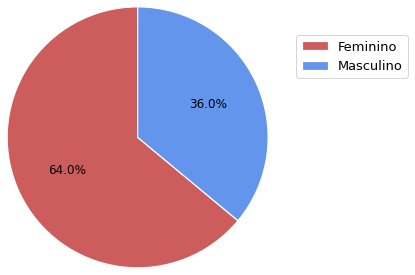

In [73]:
colors = ['indianred', 'cornflowerblue']
plt.pie(df_tromboses_sexo['Total'], autopct='%1.1f%%', startangle = 90, colors=colors, radius=1.5, textprops={'fontsize': 12},
       wedgeprops = {"edgecolor" : "white", #borda
                      'linewidth': 1.2, 
                      'antialiased': True})
plt.legend(df_tromboses_sexo['Sexo'], loc=0, bbox_to_anchor=(1.2, 1), fontsize=13)
plt.savefig('Graficos/figura 11.png',dpi=(600), bbox_inches='tight')
plt.show()

In [74]:
## PAREI AQUI em 07-01-2022

In [75]:
# Fazer análise de novas variáveis

# Raça/cor - USAR DF EVENTOS PARA GRAVE x NAO GRAVE
# Incidência de eventos por raça/cor x vacina por 1000 ds aplicadas
#df_eapv_cor = df_eventos[['RACA/COR', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE']]
#df_eapv_cor['eventos'] = 1
#df_eapv_cor

# PROBLEMA - NÃO TEMOS RAÇA COR NO BANCO EVENTOS. INSERIR

In [76]:
# explicar no boletim que o número de eventos pode ser menor do que o boletim anterior pois fichas 
# são investigadas e alteradas, atualizadas, canceladas, informações sobre COVID+ são incluidas e sobre erros de imunização.
# a análise é um recorte temporal de como o banco de dados está no momento analisado